<a href="https://colab.research.google.com/github/pinkchocoa/CSC3009-machine-learning/blob/main/ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparation

Load Dataset & Split the data into train and test sets

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import os
base_dir = "/content/drive/MyDrive/dataset_18/"
covid_path = base_dir + "covid/"
normal_path = base_dir + "normal/"
img_height = 299
img_width = 299
img_paths=[]
for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
      _, ext = os.path.splitext(filename)
      if ext == ".png":
        img_paths.append(os.path.join(dirname, filename))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Create an ImageDataGenerator instance with an 80-20 train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Define some parameters
batch_size = 32  # Change if needed

# Load images from the disk, applies rescaling, and resize the images
train_data_gen = datagen.flow_from_directory(batch_size=batch_size,
                                             directory=base_dir,
                                             shuffle=True,
                                             target_size=(img_height, img_width),
                                             class_mode='binary',
                                             subset='training')

validation_data_gen = datagen.flow_from_directory(batch_size=batch_size,
                                                  directory=base_dir,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  class_mode='binary',
                                                  subset='validation')

Found 264 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


CNN

In [6]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
CNN_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), # the 3 indicates color images
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.5), # Prevent overfitting

    Flatten(), # Flatten the output from the convolutional part of the CNN
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Output layer, 'sigmoid' for binary classification
])

# Compile the model
CNN_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print a summary of the model
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)      0

In [7]:
epochs = 20 # You can change this value

#REFERENCE: LAB05
#TODO: add full batch gradient descent
#TODO: try different batch_sizes
#TODO: start fine tuning from a certain layer
history = CNN_model.fit(train_data_gen,
                    validation_data=validation_data_gen,
                    steps_per_epoch=len(train_data_gen),
                    validation_steps=len(validation_data_gen),
                    epochs=epochs)


Epoch 1/20
9/9 [==============================] - 55s 5s/step - loss: 1.0011 - accuracy: 0.5530 - val_loss: 0.7445 - val_accuracy: 0.4545
Epoch 2/20
9/9 [==============================] - 2s 231ms/step - loss: 0.6716 - accuracy: 0.5606 - val_loss: 0.5671 - val_accuracy: 0.8333
Epoch 3/20
9/9 [==============================] - 2s 227ms/step - loss: 0.5589 - accuracy: 0.7273 - val_loss: 0.7493 - val_accuracy: 0.5758
Epoch 4/20
9/9 [==============================] - 2s 230ms/step - loss: 0.5471 - accuracy: 0.7841 - val_loss: 0.3511 - val_accuracy: 0.8636
Epoch 5/20
9/9 [==============================] - 2s 230ms/step - loss: 0.4162 - accuracy: 0.8561 - val_loss: 0.3911 - val_accuracy: 0.8182
Epoch 6/20
9/9 [==============================] - 3s 317ms/step - loss: 0.3584 - accuracy: 0.8788 - val_loss: 0.3240 - val_accuracy: 0.8485
Epoch 7/20
9/9 [==============================] - 2s 224ms/step - loss: 0.3345 - accuracy: 0.8826 - val_loss: 0.4122 - val_accuracy: 0.8939
Epoch 8/20
9/9 [======

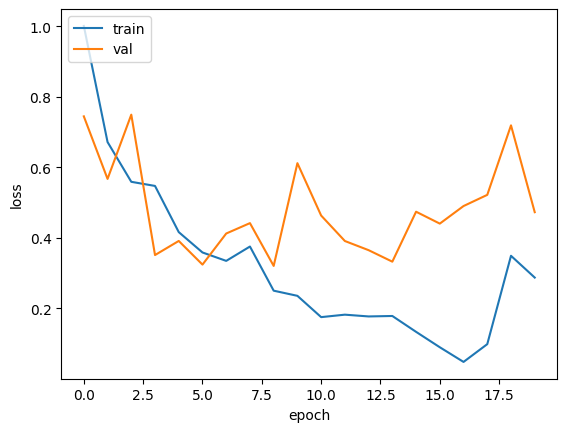

In [14]:
import pylab as plt
def plot_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
plot_history(history)

RNN

In [88]:
from sklearn.model_selection import train_test_split
#RNN cannot use ImageDataGenerator output
#preprocess datasets for RNN
import cv2
# Now, we will load images, convert to grayscale (or you can keep as RGB), normalize and flatten
data = []
labels = []

def get_label(file):
    folder_path = os.path.dirname(file)
    folder_name = os.path.basename(folder_path)
    return folder_name

for file in img_paths:
    folder_name = get_label(file)
    if folder_name == 'covid':
        labels.append(1)
    elif folder_name == 'normal':
        labels.append(0)
    else:
        print(f"Unexpected folder name {folder_name} for file {file}")

    img = cv2.imread(file)  # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    img = cv2.resize(img, (299, 299))  # resize image
    img = img / 255.0  # normalize pixel values
    data.append(img)

data = np.array(data)
labels = np.array(labels)

#TODO: change test size

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten

def build_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape,
                        activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

RNN_model = build_RNN(50, 1, (299, 299), activation=['relu', 'sigmoid'])

RNN_model.summary()



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 50)                17500     
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 17,551
Trainable params: 17,551
Non-trainable params: 0
_________________________________________________________________


Show the weights and biases of all neurons.

In [86]:
# wx = RNN_model.get_weights()[0]
# wh = RNN_model.get_weights()[1]
# bh = RNN_model.get_weights()[2]
# w0 = RNN_model.get_weights()[3]
# b0 = RNN_model.get_weights()[4]

# print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' w0 =', w0, 'b0 = ', b0)

In [92]:
import numpy as np
import random

random_index = random.randint(0, len(img_paths) - 1)
test_path = img_paths[random_index]
test_img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (299, 299))  # resize to match the model's expected input size
x = test_img / 255.0  # normalize pixel values to [0,1] as done for training data
x_input = np.reshape(x, (1, 299, 299))  # flatten height and width into single dimension
# Reshape the input to the required sample_size x time_steps x features
y_pred_model = RNN_model.predict(x_input)

print("Prediction from network (1 == covid, 0 == normal): ", y_pred_model)
print("Actual: ", get_label(img_paths[random_index]))

1/1 [==============================] - 0s 155ms/step
Prediction from network (1 == covid, 0 == normal):  [[0.05209123]]
Actual:  normal


In [93]:
epochs = 10 # Adjust as necessary
history = RNN_model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2)


Epoch 1/10
7/7 [==============================] - 4s 401ms/step - loss: 0.3006 - val_loss: 0.2252
Epoch 2/10
7/7 [==============================] - 2s 283ms/step - loss: 0.2258 - val_loss: 0.2053
Epoch 3/10
7/7 [==============================] - 1s 199ms/step - loss: 0.2237 - val_loss: 0.2037
Epoch 4/10
7/7 [==============================] - 1s 205ms/step - loss: 0.2223 - val_loss: 0.2037
Epoch 5/10
7/7 [==============================] - 1s 211ms/step - loss: 0.2188 - val_loss: 0.2009
Epoch 6/10
7/7 [==============================] - 1s 200ms/step - loss: 0.2242 - val_loss: 0.1985
Epoch 7/10
7/7 [==============================] - 1s 189ms/step - loss: 0.2196 - val_loss: 0.2015
Epoch 8/10
7/7 [==============================] - 1s 196ms/step - loss: 0.2155 - val_loss: 0.1985
Epoch 9/10
7/7 [==============================] - 1s 211ms/step - loss: 0.2148 - val_loss: 0.1987
Epoch 10/10
7/7 [==============================] - 2s 356ms/step - loss: 0.2110 - val_loss: 0.1966


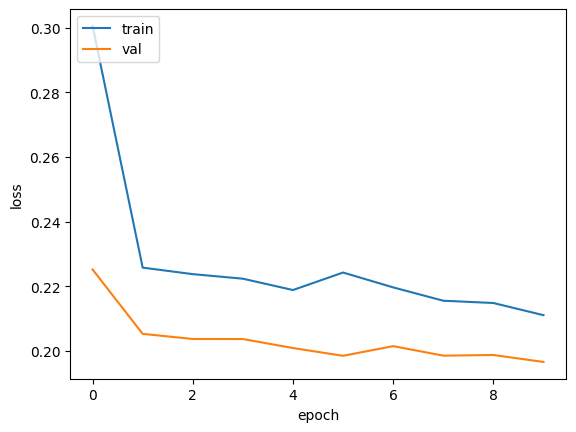

In [94]:
plot_history(history)